<a href="https://colab.research.google.com/github/lszam/gds-ssebrazil/blob/main/GDS_SSEBrazil_Etapa3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Etapa 3 - Escolha dos dados para perfil**

Dados Gravimétricos - Seleção de Dados Terrestres para um Modelo 2D

Este notebook demonstra o procedimento para analisar dados e encontrar o melhor caminho entre as localidades dos dados adquiridos. O caminho servirá de base para modelagens gravimétricas 2D, realizadas pela comunidade (Laboratório de Pesquisas em Geofísica Aplicada - LPGA, Universidade Federal do Paraná).

Para resolver o caminho, utilizamos uma abordagem do problema do caixeiro-viajante modificada. O algoritmo foi apoiado no método do Vizinho Mais Próximo, ponderado pela direção do caminho, distância com o ponto final, e gradiente geofísico (neste caso, com gravimetria). O objetivo é priorizar caminhos que sigam diretamente para o próximo ponto de restrição.

Editores:
LUIZEMARA SZAMEITAT. Graduanda em Ciência de Dados pela UNIVESP. Pós-Doutorado - UERJ, Professora Contratada - USP (contato@lszameitat.com)
CARLOS HENRIQUE SARAIVA MUZACHIO. Graduando em Engenharia de Software pela UNIVESP. Professor de Física, Química e Matemática na Rede Pública de Ensino do Estado de São Paulo.

Comunidade: Alessandra de B. e S. Bongiolo, Sol Huber e Eros K. C. Pereira (UFPR)

### Agradecimentos

Este estudo foi financiado, em parte, pelo Instituto GeoAtlântico e Conselho Nacional de Desenvolvimento Científico e Tecnológico (CNPq), bolsista de Iniciação Cinetífica Sol Huber. Este estudo foi financiado, em parte, pela Coordenação de Aperfeiçoamento de Pessoal de Nível Superior – Brasil (CAPES) – Código de Financiamento 001 (Pós Doutorado Estratégico - L. Szameitat).


In [ ]:
# INSIRA NAS VARIÁVEIS ABAIXO OS PONTOS DE ENTRADA (X1, Y1) E DE SÁIDA (X2, Y2)
X1, Y1 , X2, Y2 = 5083784, 7487413, 5532060, 7175940

# INSIRA NAS VARIÁVEIS ABAIXO OS PONTOS DE CONTROLE
Xc1, Yc1 = 5448430, 7233035
Xc2, Yc2 = 5524246, 7174624

# INSIRA O BUFFER (em porcentagem, ao longo da linha reta entre os pontos inicial e final)
buffer_factor = 0.04

# DADOS
input_file = 'https://raw.githubusercontent.com/lszam/univesp_projeto4/refs/heads/main/data/data.csv'

data = pd.read_csv(input_file)
data.head()

,X,Y,LONGITUDE,LATITUDE,AR_LIVRE,BOUGUER,h
0,5.044529e+06,6.735777e+06,-53.5408,-29.4950,-10.666622,-31.206539,192.68
1,5.050289e+06,6.735664e+06,-53.4814,-29.4958,-23.689683,-31.713608,80.73
2,5.103823e+06,6.736186e+06,-52.9294,-29.4878,37.024584,-29.976008,607.27
3,5.089187e+06,6.753250e+06,-53.0817,-29.3350,9.510169,-32.150453,380.96
4,5.013949e+06,6.755564e+06,-53.8564,-29.3172,13.454634,-36.530771,456.28


##1. Preparo do ambiente e dados de entrada
Os dados de entrada (no formato CSV) correspondem ao conjunto de dados gravimétricos previamente delimitado por uma janela.

In [ ]:
!pip install cmcrameri -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
#import cmcrameri as cm
import cmcrameri.cm as cm


# PONTOS INSERIDOS
try:
  constrained_coords = [[X1, Y1], [Xc1, Yc1], [Xc2, Yc2], [X2, Y2]]
except:
  constrained_coords = [[X1, Y1], [X2, Y2]]

# Lista com apenas as coordenadas
coordinates = data[['X', 'Y']].values

Funções

In [ ]:
def profile_tips(coordinates, X1, Y1, X2, Y2):
    '''
    Finding indexes for the starting and ending coordinates of the profile
    Encontrar indices para as coordenadas inicial e final do perfil
    '''
    import numpy as np

    target_coord1 = np.array([X1, Y1])
    target_coord2 = np.array([X2, Y2])

    distances1 = np.linalg.norm(coordinates - target_coord1, axis=1)
    distances2 = np.linalg.norm(coordinates - target_coord2, axis=1)

    index1 = np.argmin(distances1)
    index2 = np.argmin(distances2)

    return index1, index2

def extract_rectangle(data, X1, Y1, X2, Y2):
    '''
    Extract data within the rectangle defined by X1, Y1 and X2, Y2
    Extrair dados dentro do retangulo definido por X1, Y1 e X2, Y2
    '''
    min_x, max_x = min(X1, X2), max(X1, X2)
    min_y, max_y = min(Y1, Y2), max(Y1, Y2)
    inside_rectangle = (data['X'] >= min_x) & (data['X'] <= max_x) & (data['Y'] >= min_y) & (data['Y'] <= max_y)

    return data[inside_rectangle]

def profile_data_buffer(df, X1, Y1, X2, Y2, buffer_distance):
    '''
    Buffering
    Bufferizar
    '''

    if 'X' not in df.columns or 'Y' not in df.columns:
        raise KeyError("O DataFrame deve conter as colunas 'X' e 'Y'")

    # Calcular a distância de um ponto (x0, y0) até a reta definida por (X1, Y1) e (X2, Y2)
    def distance_to_line(x0, y0, X1, Y1, X2, Y2):
        # Distância ponto-reta
        return abs((Y2 - Y1) * x0 - (X2 - X1) * y0 + X2 * Y1 - Y2 * X1) / np.sqrt((Y2 - Y1)**2 + (X2 - X1)**2)

    # Fazer uma coluna de distâncias
    df['distance_to_main_line'] = df.apply(lambda row: distance_to_line(row['X'], row['Y'], X1, Y1, X2, Y2), axis=1)
    # Buffering
    filtered_df = df[df['distance_to_main_line'] <= buffer_distance].copy()
    # Limitar a área de interesse entre os pontos inicial e final
    filtered_df = extract_rectangle(filtered_df, X1, Y1, X2, Y2)

    return filtered_df

def profile_euclidean_dist(x1, y1, x2, y2):
    '''
    Euclidean distance from the main azimuth
    Distancia euclidiana da direção principal
    '''
    return math.sqrt((X2 - X1)**2 + (Y2 - Y1)**2)


In [ ]:
# Separar dados que estão na área do buffer (interest_area)
buffer_distance = profile_euclidean_dist (X1, Y1, X2, Y2) * buffer_factor #--> PARAMETRO

interest_area = profile_data_buffer(data, X1, Y1, X2, Y2, buffer_distance)
interest_coordinates = interest_area[['X', 'Y']].values

# Problema do Caixeiro-Viajante Adaptado *(Traveling Salesman Problem, TSP)*

Encontrando o caminho ideal entre os pontos inicial e final. A solução típica do TSP consiste em retornar ao mesmo ponto de partida. No entanto, neste caso, os locais de início e fim são distintos.

Aplicamos uma solução heurística baseada no algoritmo do Vizinho Mais Próximo. Após algumas modificações, esse método proporcionou uma boa aproximação do caminho ideal.


#

#

#



### Nearest Neighbor (NN)

We use KD Tree for constructing a graph structure.
For avoiding too zigzagged path, it was considered a scalar product >0. The scalar product was between vectors defined by current--->ending locations and current--->candidate locations.
It was added a constraint point for guiding the final path


In [ ]:
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt

def is_ahead(current_point, candidate_point, end_point):
    """
    Verifica se o ponto candidato está à frente do ponto atual em direção ao ponto final.
    """
    direction_to_end = end_point - current_point
    direction_to_candidate = candidate_point - current_point
    dot_product = np.dot(direction_to_end, direction_to_candidate)
    return dot_product > 0


def nearest_neighbor_kdtree(points, start_index, end_index):
    # Criar árvore KD
    kdtree = KDTree(points)

    num_points = len(points)
    visited = [False] * num_points
    path = [start_index]
    visited[start_index] = True

    current_index = start_index
    end_point = points[end_index]

    while current_index != end_index:
        nearest_distance = float('inf')
        nearest_index = -1

        # Encontra os vizinhos mais próximos que não foram visitados
        distances, indices = kdtree.query(points[current_index], k=num_points)

        for i in range(1, num_points):  # Ignora o próprio ponto (fornece erro com distância zero)
            candidate_index = indices[i]
            candidate_point = points[candidate_index]

            if not visited[candidate_index] and distances[i] < nearest_distance:
                if is_ahead(points[current_index], candidate_point, end_point):
                    nearest_distance = distances[i]
                    nearest_index = candidate_index

        if nearest_index == -1:
            break
        path.append(nearest_index)
        visited[nearest_index] = True
        current_index = nearest_index

    return path


# Encontrar as coordenadas dos pontos na área de interesse
coordinates = interest_area[['X', 'Y']].values

constrained_path = []
for i, item in enumerate(constrained_coords):
    if i==0: #pular laço para o primeiro item
        continue
    start_index, end_index = profile_tips(coordinates, constrained_coords[i-1][0], constrained_coords[i-1][1], constrained_coords[i][0], constrained_coords[i][1],)
    #print(f'Start Index: {start_index}, End Index: {end_index}')
    path = nearest_neighbor_kdtree(coordinates, start_index, end_index)
    constrained_path = constrained_path + path #concatenate paths


# Recuperar dados do dataset original e incluir no path
path_data = interest_area.iloc[constrained_path]


# Calcular a distância acumulada ao longo do perfil
distances = [0.0]
for i in range(1, len(path_data)):
    prev_point = path_data.iloc[i - 1][['X', 'Y']].values
    curr_point = path_data.iloc[i][['X', 'Y']].values
    distance = np.linalg.norm(curr_point - prev_point)
    total_dist = distances[-1] + distance
    distances.append(total_dist)


path_data['Path_Distance'] = distances
path_data = path_data.sort_values(by='Path_Distance').reset_index(drop=True)

path_data.to_csv('path_data.csv')

<ipython-input-18-e5f9f62f2755>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path_data['Path_Distance'] = distances


# Plotting maps


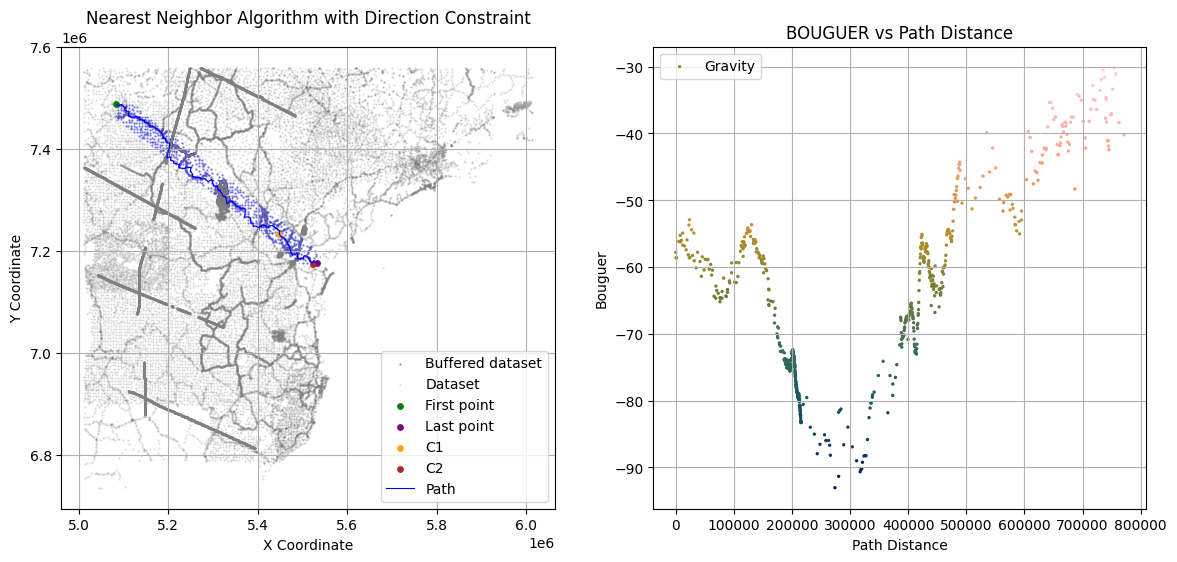

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='blue', s=0.5, alpha=0.4, label='Buffered dataset')
plt.scatter(data['X'], data['Y'], c='grey', s=0.5, label='Dataset', alpha=0.2)
plt.scatter(X1, Y1, color='green', s=15, label='First point')
plt.scatter(X2, Y2, color='purple', s=15, label='Last point')
plt.scatter(Xc1, Yc1, color='orange', s=15, label='C1')
plt.scatter(Xc2, Yc2, color='brown', s=15, label='C2')
plt.plot(path_data['X'], path_data['Y'], linestyle='-', color='b', label='Path', linewidth=0.8)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Nearest Neighbor Algorithm with Direction Constraint')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
perfil = plt.scatter(path_data['Path_Distance'], path_data['BOUGUER'], c=path_data['BOUGUER'], cmap=cm.batlow, s=2, label='Gravity')
plt.xlabel('Path Distance')
plt.ylabel('Bouguer')
plt.title('BOUGUER vs Path Distance')
plt.legend()
plt.grid(True)
plt.show()


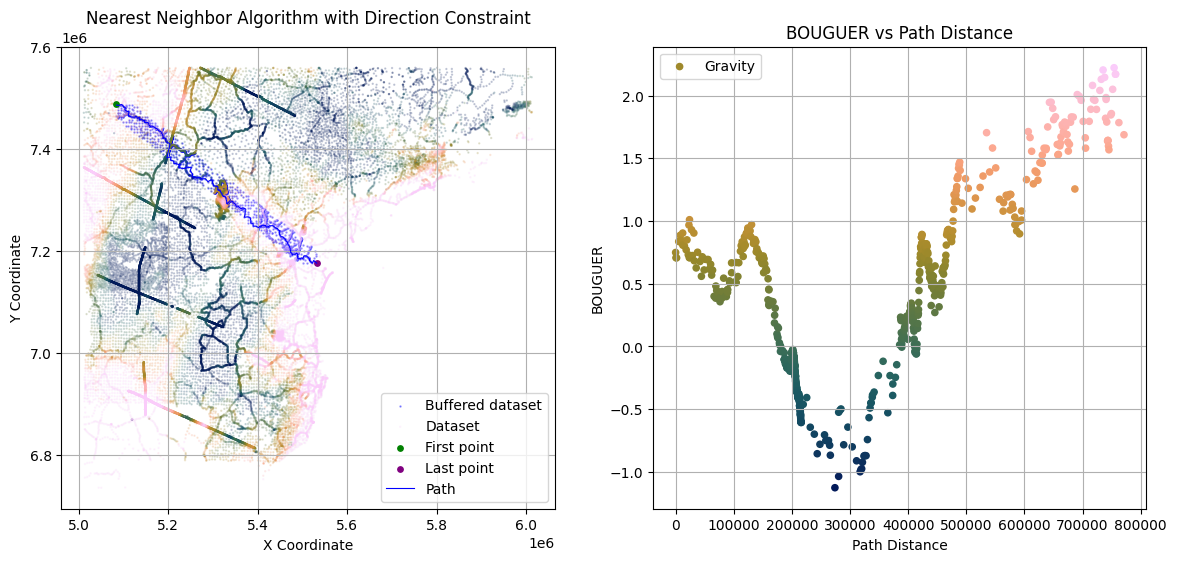

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Normalizar os valores de BOUGUER para ter uma distribuição gaussiana
scaler = StandardScaler()
data['BOUGUER_normalized'] = scaler.fit_transform(data[['BOUGUER']])
path_data['BOUGUER_normalized'] = scaler.transform(path_data[['BOUGUER']])

# Definir os limites de cores como X vezes o desvio padrão
std_dev = 1  # por exemplo, como 2x o desvio padrao
lower_limit = -std_dev
upper_limit = std_dev

# Aplicar os limites aos valores normalizados
data['BOUGUER_norm_clip'] = np.clip(data['BOUGUER_normalized'], lower_limit, upper_limit)
path_data['BOUGUER_norm_clip'] = np.clip(path_data['BOUGUER_normalized'], lower_limit, upper_limit)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='blue', s=0.5, alpha=0.4, label='Buffered dataset')
plt.scatter(data['X'], data['Y'], c=data['BOUGUER_norm_clip'], cmap=cm.batlow, s=0.5, label='Dataset', alpha=0.2)
plt.scatter(X1, Y1, color='green', s=15, label='First point')
plt.scatter(X2, Y2, color='purple', s=15, label='Last point')
#plt.scatter(Xc1, Yc1, color='orange', s=15, label='Last point')
#plt.scatter(Xc2, Yc2, color='brown', s=15, label='Last point')
plt.plot(path_data['X'], path_data['Y'], linestyle='-', color='b', label='Path', linewidth=0.8)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Nearest Neighbor Algorithm with Direction Constraint')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(path_data['Path_Distance'], path_data['BOUGUER_normalized'], c=path_data['BOUGUER_normalized'], cmap=cm.batlow, s=20, label='Gravity')
plt.xlabel('Path Distance')
plt.ylabel('BOUGUER')
plt.title('BOUGUER vs Path Distance')
plt.legend()
plt.grid(True)

plt.show()

